In [2]:
import os
from io import BytesIO
import PIL.Image as Image
import PIL.ImageOps as ImageOps
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, Callback, ModelCheckpoint
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn.functional as F
import torch.optim.lr_scheduler as lrs
import numpy as np
from time import sleep
import pandas_ta as ta
# %matplotlib inline
from tqsdk2 import TqApi, TargetPosTask, TqSim, TqBacktest, TqAccount, TqAuth, TqKq
from tqsdk2.ta import BOLL, PUBU, ENV, ATR, MACD, CCI, RSI
from datetime import date
import time
from datetime import datetime
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")

from saved_time_list import saved_time_list # 读取存储的time list
from contract_min_max import contract_min_max
# from model_list import alexnet, alexnet1d

In [3]:
def to_unix(t):
    timearray = time.strptime(t, '%Y-%m-%d %H:%M:%S')
    tt = int(time.mktime(timearray))
    return tt

def timestamp(t):
    format = '%Y-%m-%d %H:%M:%S'
    t = int(t / 1e9)
    t = time.localtime(t)
    dt = time.strftime(format, t)
    return dt

def find_target(symbol, timestr, period):
    
    # if period == 10:
    #     history = 40
    # elif period > 10:
    #     history = 20
    history = 40
    df = api.get_kline_serial(symbol, period * 60, 5000)
    df = df.dropna()
    df.loc[:, "time"] = [timestamp(t) for t in df["datetime"]]
    df.loc[:, "macd"] = MACD(df, *ma_para)["bar"]
    df.loc[:, "cci"] = CCI(df, 14) # 14 days CCI indicator
    df.loc[:, "rsi"] = RSI(df, 7) # 7 days RSI
    
    # print(f"fartest datetime acquired for {period}min is at {df['time'].iloc[0]}")
    target_index = df.loc[df["time"] == timestr].index[0]
    target_values = df[["macd", "close", "cci", "rsi"]].loc[target_index - history + 1:target_index]

    return target_values
    
def prepare_data(symbol, time_list, label, exam=True):
    temp_pd = pd.DataFrame()
    for item in time_list:
        try:
            target_values = find_target(symbol, item[0], item[1])
            temp_pd[f"macd{item[1]}"], temp_pd[f"close{item[1]}"] = list(target_values.loc[:, "macd"]), list(target_values.loc[:, "close"])
        except:
            print(f"{item[1]} is problematic")
    
    # add cci10 and rsi10 at the end of dataframe
    for item in time_list:
        if int(item[1]) == 10:
            target_values = find_target(symbol, item[0], item[1])
            temp_pd[f"cci{item[1]}"], temp_pd[f"rsi{item[1]}"] = list(target_values.loc[:, "cci"] / 200.), list(target_values.loc[:, "rsi"] / 100.) # scale cci by 200, rsi by 100
            break
    
    # another way to add cci10 and rsi10 to the end of datafram
    # cci_temp = temp_pd.pop("cci10")
    # rsi_temp = temp_pd.pop("rsi10")
    # temp_pd.insert(8, "cci10", cci_temp)
    # temp_pd.insert(9, "rsi10", rsi_temp)

    # for examination
    if exam:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex='col', constrained_layout=True)
        ax1.bar(range(40), temp_pd["macd10"], width=0.5)
        ax1.set_title(f'macd 10min at {time_list[0][0]}, mark: {label}')
        ax2.bar(range(40), temp_pd["macd15"], width=0.5)
        ax2.set_title(f'macd 15min at {time_list[1][0]}, mark: {label}')
        ax3.bar(range(40), temp_pd["macd60"], width=0.5)
        ax3.set_title(f'macd 60 at {time_list[2][0]}, mark: {label}')
        ax4.bar(range(40), temp_pd["macd1440"], width=0.5)
        ax4.set_title(f'macd day at {time_list[3][0]}, mark: {label}')
        plt.show()
    # end examination

    return temp_pd, torch.unsqueeze(torch.from_numpy(temp_pd.values), 0), torch.tensor([label])

def init_dataset(saved_time_list, exam=0):
    data_tot = torch.zeros(1, 40, 10) # initialize data_tot
    label_tot = torch.tensor([0.]) # initialize label_tot
    for item in saved_time_list:
        _, data, label = prepare_data(item[0], item[1], item[2], exam)
        data_tot = torch.cat((data_tot, data),dim=0)
        label_tot = torch.cat((label_tot, label))
    return data_tot[1:], label_tot[1:]  # exclude initial zero data        

# find the min and max close value for every symbol in data_tot, and use them to scale data_tot
# def scale_data(time_list, data_tot): 
#     local_data = deepcopy(data_tot)
#     symbol_list = []
#     for item in time_list:
#         if [item[0] , 0, 1e8] in symbol_list:
#             pass
#         else:
#             symbol_list.append([item[0], 0, 1e8])
#     for ii, item in enumerate(time_list):
#         for si, symbol in enumerate(symbol_list):
#             if item[0] == symbol[0]:
#                 max_value = torch.max(local_data[ii,:, 1:8:2])
#                 min_value = torch.min(local_data[ii,:, 1:8:2])
#                 if max_value > float(symbol[1]):
#                     symbol_list[si][1] = float(max_value)
#                 if min_value < float(symbol[2]):
#                     symbol_list[si][2] = float(min_value)
#     # print(symbol_list) # inspect symbol_list and their max values
#     for ii, item in enumerate(time_list):
#         for si, symbol in enumerate(symbol_list):
#             if item[0] == symbol[0]:
#                 local_data[ii, :, 1:8:2] = (local_data[ii, :, 1:8:2] - symbol[2]) / (symbol[1] - symbol[2]) # scale corresponding close price with min_max method
#     return symbol_list, local_data

def scale_data(time_list, data_tot, contract_min_max=contract_min_max):
    local_data = deepcopy(data_tot)
    for ii, item in enumerate(time_list):
        for contract in contract_min_max:
            if contract[0] in item[0]:
                local_data[ii, :, 1:8:2] = (local_data[ii, :, 1:8:2] - contract[1]) / (contract[2] - contract[1])
                break
        else:
            print(f"\n{item[0]} is not in contract_list! Scale it manually or add contract to contract_min_max.py.\n")
    return contract_min_max, local_data


def fig_to_mat(data, size=(320,320), lw=7.0):
    fig, ax = plt.subplots(1, 1)
    ax.plot(data, linewidth=lw)
    plt.axis('off')
    plt.margins(0, 0)
    # plt.show()
    buffer_ = BytesIO() # request cache from memory instead of disk
    plt.savefig(buffer_, format='png', bbox_inches='tight')
    buffer_.seek(0)
    pildata = Image.open(buffer_)
    pildata = pildata.resize(size) # resize image
    pildata = pildata.convert('1') # black and white mode
    pildata = ImageOps.invert(pildata) # invert True and False
    img_data = np.asarray(pildata, dtype=np.float32) # tranform True False to 1 0
    plt.close()
    buffer_.close() # release caches
    return pildata, torch.from_numpy(img_data) # return image and matrix

today = datetime.strftime(datetime.now(), "%Y-%m-%d")

def read_data(source, date=today):

    # date = datetime.strftime(datetime.now(), "%Y-%m-%d")
    if source == 'tqsdk': # not available in jupyter
        global api
        api = TqApi(TqKq(), auth=TqAuth("", ""))
        print(f"\nlength of saved_time_list is: {len(saved_time_list)}\n")
        data_tot, label_tot = init_dataset(saved_time_list, exam=0)
        load_data = TensorDataset(data_tot.to(torch.float32), label_tot)
        torch.save(load_data, f"./data/macd_datasets_{date}.pt") # save data to file
        api.close()
    else:
        load_data = torch.load(f"./data/macd_datasets_{date}.pt")
        print(f"\nshape of loaded data is: {load_data.tensors[0].shape}\n")
    return load_data

def prepare_img_datasets(load_data, data_dim=2, need_symbol_list=False):
    target_dataset = load_data.tensors[0].transpose(1,2)

    if data_dim == 2:
        print("\ntransforming to 2D data")
        ## 转为二维图片
        img_size = (300, 300)
        linewidth = 9
        shape_of_datasets = target_dataset.shape
        img_datasets = torch.zeros(shape_of_datasets[0], shape_of_datasets[1], img_size[0], img_size[1])
        for i in range(img_datasets.shape[0]):
            for j in range(img_datasets.shape[1]):
                _, img_datasets[i, j] = fig_to_mat(target_dataset[i, j], size=img_size, lw=linewidth)

        print(f"\nshape of datasets is: {img_datasets.shape} \n")
        plt.imshow(img_datasets[0,1]) # show a picture
        return img_datasets
    else:
        print("\nUse 1d dataset")
        symbol_list, img_datasets = scale_data(saved_time_list, target_dataset.transpose(1,2))
        img_datasets = img_datasets.transpose(1,2)
        print(f"\nshape of datasets is: {img_datasets.shape} \n")
        if need_symbol_list:
            return symbol_list, img_datasets
        else:
            return img_datasets


def prepare_dataloader(img_datasets, target_label, bs=32, label_type='binary', test=True, one_hot_label=False):
    # build dataloader
    scaled_label = target_label / 10.0
    binary_label = torch.tensor((scaled_label > 0), dtype=torch.float32) # 只判断macd信号对错不考虑幅值    
    
    if label_type == "scaled":
        print("\nUse scaled label \n")
        datasets_trans = TensorDataset(img_datasets, torch.unsqueeze(scaled_label, dim=1)) # 使用scaled label
    elif label_type == "binary":
        print("\nUse binary label \n")
        if one_hot_label:
            print("Enable one-hot encoding")
            datasets_trans = TensorDataset(img_datasets, F.one_hot(torch.tensor([int(i) for i in binary_label])).to(torch.float32)) # 使用binary label并进行one-hot编码
        else:
            print("Disable one-hot encoding")
            datasets_trans = TensorDataset(img_datasets, torch.unsqueeze(binary_label, dim=1)) # 使用binary label不进行one-hot编码

    if test: # add test loader
        print("\nenable test loader")
        train_data_size = int(len(img_datasets) * 0.7) # 70%
        val_data_size = int((len(img_datasets) - train_data_size) / 2) # 15%
        test_data_size = len(img_datasets) - train_data_size - val_data_size # 15% 

        train_dataset, val_dataset, test_dataset = random_split(datasets_trans, [train_data_size, val_data_size, test_data_size])
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size = bs,
            shuffle=True
        )
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=len(val_dataset),
            shuffle=False
        )    
        test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=len(test_dataset),
            shuffle=False
        )
        return train_loader, val_loader, test_loader
    else: # use only train and val loader
        print("\nno test loader")
        train_data_size = int(len(img_datasets) * 0.8) # 80%
        val_data_size = int((len(img_datasets) - train_data_size)) # 20%

        train_dataset, val_dataset = random_split(datasets_trans, [train_data_size, val_data_size])
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size = bs,
            shuffle=True
        )
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=len(val_dataset),
            shuffle=False
        )    
        return train_loader, val_loader
    

## macd and atr parameters
ma_para = [13,34,9]
atr_para = [13]

In [4]:
## build model
class FocalLoss(nn.Module):
    def __init__(self,alpha=0.25, gamma=2.0,use_sigmoid=True):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.use_sigmoid = use_sigmoid
        if use_sigmoid:
            self.sigmoid = nn.Sigmoid()
 
    def forward(self, pred: torch.Tensor, target: torch.Tensor):
        """
        Focal loss
        :param pred: shape=(B,  HW)
        :param label: shape=(B, HW)
        """
        if self.use_sigmoid:
            pred = self.sigmoid(pred)
        pred = pred.view(-1)
        label = target.view(-1)
        pos = torch.nonzero(label > 0).squeeze(1)
        pos_num = max(pos.numel(),1.0)
        mask = ~(label == -1)
        pred = pred[mask]
        label= label[mask]
        focal_weight = self.alpha *(label- pred).abs().pow(self.gamma) * (label> 0.0).float() + (1 - self.alpha) * pred.abs().pow(self.gamma) * (label<= 0.0).float()
        loss = F.binary_cross_entropy(pred, label, reduction='none') * focal_weight
        return loss.sum()/pos_num

class alexnet1d(nn.Module):
    def __init__(self, input_channels=8, out_dim=1, first_kernel=7):
        super(alexnet1d, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=first_kernel, stride=2, padding=1), nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            nn.Conv1d(64, 128, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            nn.Conv1d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv1d(256, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.LazyLinear(2048), nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(1024), nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(512), nn.ReLU(),
            nn.Dropout(0.5),
            nn.LazyLinear(out_dim),
        )
    def forward(self, x):
        y = self.model(x)
        return y

In [5]:
# predict exclusive functions
def predict_on_target(net, channels, target_data):
  with torch.no_grad():
    net = net.to('cpu')
    net.eval()
    predict = F.softmax(net(target_data[:, channels].to(torch.float32)))
    return predict
  
def analysis_result(predict_list):
    tensor_list = torch.tensor(sorted(predict_list, reverse=True), dtype=torch.float32)
    print(f"模型最佳准确率为: {tensor_list[0,0]:.2f}\n")
    print(f"前二十预测结果中预测为正的占比为: {tensor_list[:20, 1:].max(1)[1].sum() / 20.:.2f}")
    print(f"所有trials中预测为正的占比为: {tensor_list[:, 1:].max(1)[1].sum() / len(tensor_list):.2f}")
    return tensor_list

def get_predictions(target_time_list, target_data, source, nni_model_num=100):

    if target_time_list[0] +' '+ target_time_list[1][0][0] in np.array(load_model_predict_record).reshape(-1):
    # if 0: # for test
        print("\nPrediction for the target has been recorded ! ")
        return None

    else:
        if source == 'batch': # load saved batch models for predictions
            print(f"\nRunning macd prediction process for {target_time_list[0]} {target_time_list[1][0][0]} by model batch")
            predict_list = []
            for load_batch in range(10): 
                model_info = torch.load(f"e:\\ml_data\\model_checkpoints\\model_list_batch_{load_batch}.pth")
                load_channels = model_info["channels"]
                for state_dict in model_info["top_ten_models"]:
                    load_model = alexnet1d(len(load_channels), 2)
                    load_model.load_state_dict(state_dict)
                    predict = torch.squeeze(predict_on_target(load_model, load_channels, target_data)).tolist()
                    predict_list.append(predict)

            print(f"\nIn {len(predict_list)} predictions from loaded batch model:\ninstances predict POSITIVE: {torch.tensor(predict_list).max(1)[1].sum()}\ninstances predict NEGATIVE: {torch.tensor(predict_list).min(1)[1].sum()} ")
            return predict_list
        
        elif source == 'nni': # load saved NNI models for predictions
            print(f"\nRunning macd prediction process for {target_time_list[0]} {target_time_list[1][0][0]} by NNI models")
            predict_list = []
            model_acc_list = []
            best_acc = 0
            for trial in range(nni_model_num): # should have 100 models 
                model_info = torch.load(f"e:\\ml_data\\model_checkpoints\\model_nni_enismkr2_{trial}.pth")
                load_channels = model_info["channels"]
                state_dict = model_info["best_model"]
                model_acc = model_info["acc"]
                load_model = alexnet1d(len(load_channels), 2)
                load_model.load_state_dict(state_dict)
                predict = torch.squeeze(predict_on_target(load_model, load_channels, target_data)).tolist()
                predict_list.append(predict)
                model_acc_list.append(model_acc)
                if model_acc > best_acc:
                    best_acc = model_acc
                    best_model_predict = torch.tensor([predict]).max(1)[1]

            print(f"\nIn {len(predict_list)} predictions from loaded batch model:\ninstances predict POSITIVE: {torch.tensor(predict_list).max(1)[1].sum()}\ninstances predict NEGATIVE: {torch.tensor(predict_list).min(1)[1].sum()}\nBest model with acc: {best_acc}, predict: {best_model_predict.item()} ")

            return model_acc_list, predict_list
        
def get_realtime_prediction(target_data, source='nni', exp_name='enismkr2', nni_model_num=100):
    if source == 'batch': # load saved batch models for predictions
        # print(f"\nRunning macd prediction process for {target_time_list[0]} {target_time_list[1][0][0]} by model batch")
        predict_list = []
        for load_batch in range(10): 
            model_info = torch.load(f"e:\\ml_data\\model_checkpoints\\model_list_batch_{load_batch}.pth")
            load_channels = model_info["channels"]
            for state_dict in model_info["top_ten_models"]:
                load_model = alexnet1d(len(load_channels), 2)
                load_model.load_state_dict(state_dict)
                predict = torch.squeeze(predict_on_target(load_model, load_channels, target_data)).tolist()
                predict_list.append(predict)

        # print(f"\nIn {len(predict_list)} predictions from loaded batch model:\ninstances predict POSITIVE: {torch.tensor(predict_list).max(1)[1].sum()}\ninstances predict NEGATIVE: {torch.tensor(predict_list).min(1)[1].sum()} ")
        pos_res = torch.tensor(predict_list).max(1)[1].sum().item()
        neg_res = torch.tensor(predict_list).min(1)[1].sum().item()
        return pos_res, neg_res  
    
    elif source == 'nni': # load saved NNI models for predictions
        # print(f"\nRunning macd prediction process for {target_time_list[0]} {target_time_list[1][0][0]} by NNI models")
        predict_list = []
        model_acc_list = []
        best_acc = 0
        for trial in range(nni_model_num): # should have 100 models 
            model_info = torch.load(f"e:\\ml_data\\model_checkpoints\\model_nni_{exp_name}_{trial}.pth")
            load_channels = model_info["channels"]
            state_dict = model_info["best_model"]
            model_acc = model_info["acc"]
            if "first_kernel" in model_info.keys():
                first_kernel = model_info["first_kernel"]
                load_model = alexnet1d(len(load_channels), 2, first_kernel)
            else:
                load_model = alexnet1d(len(load_channels), 2)
            load_model.load_state_dict(state_dict)
            predict = torch.squeeze(predict_on_target(load_model, load_channels, target_data)).tolist()
            predict_list.append(predict)
            model_acc_list.append(model_acc)
            if model_acc > best_acc:
                best_acc = model_acc
                best_model_predict = torch.tensor([predict]).max(1)[1]

        # print(f"\nIn {len(predict_list)} predictions from loaded batch model:\ninstances predict POSITIVE: {torch.tensor(predict_list).max(1)[1].sum()}\ninstances predict NEGATIVE: {torch.tensor(predict_list).min(1)[1].sum()}\nBest model with acc: {best_acc}, predict: {best_model_predict.item()} ")
        pos_res = torch.tensor(predict_list).max(1)[1].sum().item()
        neg_res = torch.tensor(predict_list).min(1)[1].sum().item()
        return pos_res, neg_res, best_model_predict.item(), best_acc
    
def real_time_predict(exp_name_list=["enismkr2", "r4c7esy9"], interval=50): # read saved exp models to predict
# realtime predict
    df = pd.DataFrame(columns=["macd10","close10", "macd15", "close15", "macd60", "close60", "macd1440", "close1440", "cci10", "rsi10"])
    
    while True:
        api.wait_update()
        for symbol in inspect_symbol_list:
            df["macd10"] = MACD(api.get_kline_serial(symbol, 10 * 60, 800), *ma_para)["bar"].iloc[-40:].tolist()
            df["close10"] = api.get_kline_serial(symbol, 10 * 60, 800)["close"].iloc[-40:].tolist()
            df["cci10"] = (CCI(api.get_kline_serial(symbol, 10 * 60, 800), 14).iloc[-40:] / 200.)["cci"].to_list()
            df["rsi10"] = (RSI(api.get_kline_serial(symbol, 10 * 60, 800), 7).iloc[-40:] / 100.)["rsi"].to_list()
            df["macd15"] = MACD(api.get_kline_serial(symbol, 15 * 60, 800), *ma_para)["bar"].iloc[-41:-1].tolist()
            df["close15"] = api.get_kline_serial(symbol, 15 * 60, 800)["close"].iloc[-41:-1].tolist()
            df["macd60"] = MACD(api.get_kline_serial(symbol, 60 * 60, 800), *ma_para)["bar"].iloc[-41:-1].tolist()
            df["close60"] = api.get_kline_serial(symbol, 60 * 60, 800)["close"].iloc[-41:-1].tolist()
            df["macd1440"] = MACD(api.get_kline_serial(symbol, 24 * 60 * 60, 800), *ma_para)["bar"].iloc[-41:-1].tolist()
            df["close1440"] = api.get_kline_serial(symbol, 24 * 60 * 60, 800)["close"].iloc[-41:-1].tolist()

            target_data = torch.unsqueeze(torch.from_numpy(df.values), 0)
            
            if data_dim == 1:
                _, target_data = scale_data([[symbol]], target_data)
                target_data = target_data.transpose(1,2)

            elif data_dim == 2:
                img_size = (300, 300)
                linewidth = 9
                img_data = torch.zeros(target_data.shape[0], target_data.shape[1], img_size[0], img_size[1])    
                for j in range(target_data.shape[1]):
                    _, img_data[0, j] = fig_to_mat(target_data[0, j], size=img_size, lw=linewidth)

            for exp_name in exp_name_list:
                if ' 15:05' in datetime.now().strftime('%Y-%m-%d %H:%M:%S') or ' 23:05' in datetime.now().strftime('%Y-%m-%d %H:%M:%S'):
                    break
                pos_res, neg_res, best_model_predict, best_acc = get_realtime_prediction(target_data, "nni", exp_name=exp_name)
                print(f"exp_{exp_name} {symbol}: POS: {pos_res}, NEG: {neg_res}, best_predict: {best_model_predict} with acc {best_acc} at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
                # pos_res, neg_res, best_model_predict = get_realtime_prediction(target_data, "nni", 'r4c7esy9')
                # print(f"exp_r4c7esy9 {symbol}: POS: {pos_res}, NEG: {neg_res}, best_predict: {best_model_predict} at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            print("\n")
        print('\n','-'*50, '\n')
        sleep(interval)
        if ' 15:05' in datetime.now().strftime('%Y-%m-%d %H:%M:%S') or ' 23:05' in datetime.now().strftime('%Y-%m-%d %H:%M:%S'):
            print("Market Close\n")
            break
    
        

In [6]:
inspect_symbol_list = [
    "CZCE.MA309",
    "SHFE.bu2306",
    "CZCE.TA309",
    "SHFE.fu2309",
    "SHFE.ru2309",
    "DCE.p2309",
    "DCE.y2309",
    "CZCE.OI309",
    "DCE.a2309",
    "DCE.m2309",
    "SHFE.rb2310",
    "DCE.i2309",
    "DCE.jm2309",
    "CZCE.SR309",
    "CZCE.CF309",
    "CZCE.SA309",
    "SHFE.sp2309",
]

day_only_symbol = [
    "CZCE.AP310",
    "DCE.jd2309",
    "CZCE.SM309",
    "CZCE.SF309",
]
if int(datetime.now().strftime('%Y-%m-%d %H:%M:%S')[11:13]) <= 14:
    for symbol in day_only_symbol:
        inspect_symbol_list.append(symbol)

# model and data parameters
pl.seed_everything(42)
load_data = read_data("file", date='2023-03-30')
saved_time_list = saved_time_list[:len(load_data.tensors[1])]
data_dim = 1 # use 1D or 2D data
symbol_list, img_datasets = prepare_img_datasets(load_data, data_dim=data_dim, need_symbol_list=True)

label_type = "binary" # binary or scaled, default binary 
one_hot_label = True # enable one-hot encoding or not
need_test = False # need test loader or not

used_net = "alexnet1d"
batch_size = 96 # 由NNI调参决定
channels = [0, 1, 2, 8] # 由NNI调参决定
patient = 9 # 训练达到一定精度之后，经过多少epoch停止训练，由NNI调参决定
threshold = 0.88 # 由NNI调参决定

out_dim = 2 if label_type == "binary" and one_hot_label else 1 # 如果使用二元label以及启用one-hot，模型输出维度为2

load_model_predict_record = []

Global seed set to 42



shape of loaded data is: torch.Size([400, 40, 10])


Use 1d dataset

shape of datasets is: torch.Size([400, 10, 40]) 



In [7]:
api = TqApi(TqKq(), auth=TqAuth("jimsapps", ""))

在使用天勤量化之前，默认您已经知晓并同意以下免责条款，如果不同意请立即停止使用：https://www.shinnytech.com/blog/disclaimer/
2023-04-07 21:07:26.820262 - 通知: 账户  与交易服务器的网络连接已建立.
2023-04-07 21:07:27.273897 - 通知: 账户 74fcb0b2-3096-4f69-acaf-9e0144c6930f 登录成功
2023-04-07 21:07:27.363042 - 通知: 与合约服务器的网络连接已建立.


In [8]:
real_time_predict(exp_name_list=["enismkr2", "r4c7esy9", "596v38c2_price"], interval=100)

exp_enismkr2 CZCE.MA309: POS: 78, NEG: 22, best_predict: 1 with acc 0.81429 at 2023-04-07 21:07:31
exp_r4c7esy9 CZCE.MA309: POS: 66, NEG: 34, best_predict: 0 with acc 0.75 at 2023-04-07 21:07:33
exp_596v38c2_price CZCE.MA309: POS: 57, NEG: 43, best_predict: 1 with acc 0.775 at 2023-04-07 21:07:36


exp_enismkr2 SHFE.bu2306: POS: 71, NEG: 29, best_predict: 1 with acc 0.81429 at 2023-04-07 21:07:38
exp_r4c7esy9 SHFE.bu2306: POS: 65, NEG: 35, best_predict: 0 with acc 0.75 at 2023-04-07 21:07:41
exp_596v38c2_price SHFE.bu2306: POS: 28, NEG: 72, best_predict: 1 with acc 0.775 at 2023-04-07 21:07:43


exp_enismkr2 CZCE.TA309: POS: 61, NEG: 39, best_predict: 1 with acc 0.81429 at 2023-04-07 21:07:46
exp_r4c7esy9 CZCE.TA309: POS: 38, NEG: 62, best_predict: 1 with acc 0.75 at 2023-04-07 21:07:48
exp_596v38c2_price CZCE.TA309: POS: 44, NEG: 56, best_predict: 1 with acc 0.775 at 2023-04-07 21:07:50


exp_enismkr2 SHFE.fu2309: POS: 83, NEG: 17, best_predict: 1 with acc 0.81429 at 2023-04-07 21:07:

In [47]:
## 查看保存的模型统计
df = pd.DataFrame(columns=["596v38c2", "r4c7esy9", "enismkr2", "596v38c2_price"], data=[])

for name in ["596v38c2", "r4c7esy9", "enismkr2", "596v38c2_price"]:
    acc_list = []
    for i in range(100):
        model_info = torch.load(f"e:\\ml_data\\model_checkpoints\\model_nni_{name}_{i}.pth")
        acc = model_info["acc"]
        acc_list.append(acc)

    df[f"{name}"] = acc_list

df.describe()

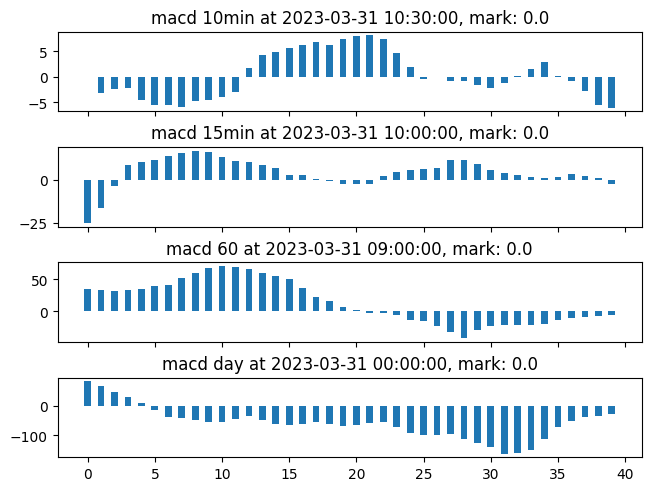


Running macd prediction process for SHFE.sp2305 2023-03-31 10:30:00 by NNI models

In 100 predictions from loaded batch model:
instances predict POSITIVE: 51
instances predict NEGATIVE: 49
Best model with acc: 0.81429, predict: 1 


In [70]:
# single run
# api.wait_update() # 盘中可以取消注释
# target time list
target_time_list = ['SHFE.sp2305',
  [['2023-03-31 10:30:00', 10],
   ['2023-03-31 10:00:00', 15],
   ['2023-03-31 09:00:00', 60],
   ['2023-03-31 00:00:00', 1440]], 0.0]

target_df, target_data, _ = prepare_data(target_time_list[0], target_time_list[1], target_time_list[2], exam=True)

if data_dim == 1:
   _, target_data = scale_data([target_time_list], target_data)
   target_data = target_data.transpose(1,2)

elif data_dim == 2:
  img_size = (300, 300)
  linewidth = 9
  img_data = torch.zeros(target_data.shape[0], target_data.shape[1], img_size[0], img_size[1])    
  for j in range(target_data.shape[1]):
      _, img_data[0, j] = fig_to_mat(target_data[0, j], size=img_size, lw=linewidth)    


model_acc_list, predict_list = get_predictions(target_time_list, target_data, "nni", 100)

In [48]:
    # record the prediction
today = datetime.strftime(datetime.now(), "%Y-%m-%d")

load_model_predict_record.append(
[
    target_time_list[0] +' '+ target_time_list[1][0][0],
    str(torch.tensor(predict_list).max(1)[1].sum().item()),
    str(torch.tensor(predict_list).min(1)[1].sum().item()),
]
)
predict_record_df = pd.DataFrame(columns=["contract and time point", "positive", "negative"], data=load_model_predict_record)
predict_record_df.to_csv(f"e:\\ml_data\\predict_record\\record_{today}.csv", index=False)
load_model_predict_record

[['DCE.p2305 2023-03-30 09:40:00', '84', '16'],
 ['DCE.jm2305 2023-03-30 11:00:00', '43', '57'],
 ['SHFE.sp2305 2023-03-30 11:20:00', '62', '38'],
 ['SHFE.sp2305 2023-03-30 11:20:00', '62', '38'],
 ['CZCE.SA305 2023-03-30 13:40:00', '88', '12'],
 ['CZCE.CF305 2023-03-30 11:00:00', '30', '70'],
 ['CZCE.CF305 2023-03-30 10:40:00', '29', '71'],
 ['CZCE.CF305 2023-03-30 13:50:00', '84', '16'],
 ['SHFE.ru2305 2023-03-30 14:00:00', '80', '20']]

In [ ]:
trial_acc_list = []
max_trial = 100 if data_dim == 1 else 50

print(f"\nRunning macd prediction process for {target_time_list[0]} {target_time_list[1][0][0]}")
for trial in range(max_trial):
    train_loader, test_loader = prepare_dataloader(img_datasets, load_data.tensors[1], batch_size, label_type, test=False, one_hot_label=one_hot_label) # use different dataloader for every trial
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'
    # used_net = "alexnet1d"
    net = alexnet1d(len(channels), out_dim).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss() if out_dim == 2 else nn.MSELoss()
    # criterion = nn.BCEWithLogitsLoss()
    # criterion = FocalLoss()
    scheduler = lrs.StepLR(optimizer, step_size=5 ,gamma=0.85)
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    tolerance = 0 # 由NNI调参决定
    max_epochs = 200

    for epoch in range(max_epochs):
        net.train()
        for batch, (data, label) in enumerate(train_loader):
            data = data[:,channels].to(device)
            label = label.to(device)

            logits = net(data)
            loss = criterion(logits, label)
            train_loss.append(loss.item() / len(data))

            if label_type == 'binary':
                if one_hot_label: 
                    acc = logits.max(1)[1].eq(label.max(1)[1]).sum().item() / len(label)
                else:
                    acc = ((logits.flatten() > 0.5 ).flatten() == label.flatten()).sum().item() / len(label)
            else:
                count = 0
                for item in (torch.cat((logits, label), 1) > 0):
                    if item[0] == item[1]:
                        count += 1
                acc = count / len(label)
            train_acc.append(acc)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if batch % 2 == 0:
                print(f"Train Epoch {epoch}, lr: {optimizer.param_groups[0]['lr']:.6f}, {batch * len(data)}/{len(train_loader.dataset)}, avg loss: {loss.item() / len(data):.6f}, train_acc: {train_acc[-1]:.2f}")
        scheduler.step() # update learning rate after an epoch

        with torch.no_grad():
            net.eval()
            for data, label in test_loader:
                data = data[:, channels].to(device)
                label = label.to(device)
                
                logits = net(data)
                loss = criterion(logits, label)
                
                if label_type == 'binary':
                    if one_hot_label: 
                        acc = logits.max(1)[1].eq(label.max(1)[1]).sum().item() / len(label)
                    else:
                        acc = ((logits.flatten() > 0.5 ).flatten() == label.flatten()).sum().item() / len(label)
                else:
                    count = 0
                    for item in (torch.cat((logits, label), 1) > 0):
                        if item[0] == item[1]:
                            count += 1
                    acc = count / len(label)
                test_acc.append(acc)

                # print(((net(data).flatten() > 0.5 ) == label.flatten()).sum() / len(data))

                test_loss.append(loss.item() / len(data))

            print(f"{used_net}, trial.{trial}:\nEpoch {epoch}, avg test_loss: {loss.item() / len(data):.6f}, test_acc: {acc:.2f}")
        
        if train_acc[-1] >= threshold: # early stop
            tolerance += 1
            print(f"\ntrain data has been fully fitted. Stop training process in 5 epochs. tolerance = {tolerance}")
            if tolerance >= patient:
                print("\nTraining stop")
                break

    # torch.save(net.state_dict(), f"e:\\ml_data\\model_checkpoints\\{used_net}_{today}_{len(saved_time_list)}_{int(test_acc[-1] * 100)}_{channels}_{label_type}.pth")

    with torch.no_grad():
        net = net.to('cpu')
        net.eval()
        for data, label in test_loader:
            # if label.max() == 1. and label.min() == 0.:
            if label_type == "binary" and not one_hot_label:
                result = torch.cat((torch.tensor(net(data[:, channels]) > 0.5, dtype=torch.float32), label),1)
            elif label_type == "binary" and one_hot_label:
                result = torch.stack((net(data[:, channels]).max(1)[1], label.max(1)[1]), 1)
                pos_corr = 0
                neg_corr = 0
                for res in result:
                    if res[0] == res[1] and res[1] == 1.:
                        pos_corr += 1
                    elif res[0] == res[1] and res[1] == 0.:
                        neg_corr += 1
                print(f"在{len(result)}个结果中:\n正确信号{sum([item[1] == 1 for item in result])}个\n错误信号{sum([item[1] == 0 for item in result])}个\n信号正确并预测正确的概率为{round(pos_corr/len(result), 3)}\n信号错误并预测正确的概率为{round(neg_corr/len(result),3)}\n总正确率为{sum([item[0] == item[1] for item in result])/len(result):.2f}")
            
            else:
                count = 0
                for item in torch.cat((net(data[:, channels]), label), 1) > 0:
                    if item[0] == item[1]:
                        count += 1
                result = torch.cat((net(data[:, channels]), label), 1) > 0
                pos_corr = 0
                neg_corr = 0
                for res in result:
                    if res[0] == res[1] and res[1] == True:
                        pos_corr += 1
                    elif res[0] == res[1] and res[1] == False:
                        neg_corr += 1          
                print(f"在{len(result)}个结果中:\n正确信号{sum([item[1] == 1 for item in result])}个\n错误信号{sum([item[1] == 0 for item in result])}个\n信号正确并预测正确的概率为{round(pos_corr/len(result), 3)}\n信号错误并预测正确的概率为{round(neg_corr/len(result),3)}\n总正确率为{sum([item[0] == item[1] for item in result])/len(result):.2f}")
    predict = torch.squeeze(predict_on_target(net, channels, target_data)).tolist()
    trial_acc_list.append([test_acc[-1], *predict])

predict_tensor_list = analysis_result(trial_acc_list)

In [ ]:
predict_tensor_list[:, 1:]

In [162]:
parameter_set = {
    "channels": [
        0,
        1,
        3,
        9
    ],
    "batch_size": 56,
    "threshold": 0.88,
    "patient": 4
} # copy from NNI web as json file

channels = parameter_set["channels"] # 由NNI调参决定
batch_size = parameter_set["batch_size"] # 由NNI调参决定
threshold = parameter_set["threshold"] # 由NNI调参决定
patient = parameter_set["patient"] # 训练达到一定精度之后，经过多少epoch停止训练，由NNI调参决定
print(channels, batch_size, threshold, patient)

[0, 1, 3, 9] 56 0.88 4


In [163]:
## find candidate model based on parameter sets
trial_acc_list = []
max_trial = 200 if data_dim == 1 else 50
# model_list = []
# print(f"\nRunning macd prediction process for {target_time_list[0]} {target_time_list[1][0][0]}")
print("\nGenerate candidate models for evaluations")
for trial in range(max_trial):
    train_loader, test_loader = prepare_dataloader(img_datasets, load_data.tensors[1], batch_size, label_type, test=False, one_hot_label=one_hot_label) # use different dataloader for every trial
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'
    # used_net = "alexnet1d"
    net = alexnet1d(len(channels), out_dim).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss() if out_dim == 2 else nn.MSELoss()
    # criterion = nn.BCEWithLogitsLoss()
    # criterion = FocalLoss()
    scheduler = lrs.StepLR(optimizer, step_size=5 ,gamma=0.85)
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    tolerance = 0 # 由NNI调参决定
    max_epochs = 200

    for epoch in range(max_epochs):
        net.train()
        for batch, (data, label) in enumerate(train_loader):
            data = data[:,channels].to(device)
            label = label.to(device)

            logits = net(data)
            loss = criterion(logits, label)
            train_loss.append(loss.item() / len(data))

            if label_type == 'binary':
                if one_hot_label: 
                    acc = logits.max(1)[1].eq(label.max(1)[1]).sum().item() / len(label)
                else:
                    acc = ((logits.flatten() > 0.5 ).flatten() == label.flatten()).sum().item() / len(label)
            else:
                count = 0
                for item in (torch.cat((logits, label), 1) > 0):
                    if item[0] == item[1]:
                        count += 1
                acc = count / len(label)
            train_acc.append(acc)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if batch % 2 == 0:
                print(f"Train Epoch {epoch}, lr: {optimizer.param_groups[0]['lr']:.6f}, {batch * len(data)}/{len(train_loader.dataset)}, avg loss: {loss.item() / len(data):.6f}, train_acc: {train_acc[-1]:.2f}")
        scheduler.step() # update learning rate after an epoch

        with torch.no_grad():
            net.eval()
            for data, label in test_loader:
                data = data[:, channels].to(device)
                label = label.to(device)
                
                logits = net(data)
                loss = criterion(logits, label)
                
                if label_type == 'binary':
                    if one_hot_label: 
                        acc = logits.max(1)[1].eq(label.max(1)[1]).sum().item() / len(label)
                    else:
                        acc = ((logits.flatten() > 0.5 ).flatten() == label.flatten()).sum().item() / len(label)
                else:
                    count = 0
                    for item in (torch.cat((logits, label), 1) > 0):
                        if item[0] == item[1]:
                            count += 1
                    acc = count / len(label)
                test_acc.append(acc)

                # print(((net(data).flatten() > 0.5 ) == label.flatten()).sum() / len(data))

                test_loss.append(loss.item() / len(data))

            print(f"{used_net}, trial.{trial}:\nEpoch {epoch}, avg test_loss: {loss.item() / len(data):.6f}, test_acc: {acc:.2f}")
        
        if train_acc[-1] >= threshold: # early stop
            tolerance += 1
            print(f"\ntrain data has been fully fitted. Stop training process in 5 epochs. tolerance = {tolerance}")
            if tolerance >= patient:
                print("\nTraining stop")
                break

    # torch.save(net.state_dict(), f"e:\\ml_data\\model_checkpoints\\{used_net}_{today}_{len(saved_time_list)}_{int(test_acc[-1] * 100)}_{channels}_{label_type}.pth")

    with torch.no_grad():
        net = net.to('cpu')
        net.eval()
        for data, label in test_loader:
            # if label.max() == 1. and label.min() == 0.:
            if label_type == "binary" and not one_hot_label:
                result = torch.cat((torch.tensor(net(data[:, channels]) > 0.5, dtype=torch.float32), label),1)
            elif label_type == "binary" and one_hot_label:
                result = torch.stack((net(data[:, channels]).max(1)[1], label.max(1)[1]), 1)
                pos_corr = 0
                neg_corr = 0
                for res in result:
                    if res[0] == res[1] and res[1] == 1.:
                        pos_corr += 1
                    elif res[0] == res[1] and res[1] == 0.:
                        neg_corr += 1
                print(f"在{len(result)}个结果中:\n正确信号{sum([item[1] == 1 for item in result])}个\n错误信号{sum([item[1] == 0 for item in result])}个\n信号正确并预测正确的概率为{round(pos_corr/len(result), 3)}\n信号错误并预测正确的概率为{round(neg_corr/len(result),3)}\n总正确率为{sum([item[0] == item[1] for item in result])/len(result):.2f}")
            
            else:
                count = 0
                for item in torch.cat((net(data[:, channels]), label), 1) > 0:
                    if item[0] == item[1]:
                        count += 1
                result = torch.cat((net(data[:, channels]), label), 1) > 0
                pos_corr = 0
                neg_corr = 0
                for res in result:
                    if res[0] == res[1] and res[1] == True:
                        pos_corr += 1
                    elif res[0] == res[1] and res[1] == False:
                        neg_corr += 1          
                print(f"在{len(result)}个结果中:\n正确信号{sum([item[1] == 1 for item in result])}个\n错误信号{sum([item[1] == 0 for item in result])}个\n信号正确并预测正确的概率为{round(pos_corr/len(result), 3)}\n信号错误并预测正确的概率为{round(neg_corr/len(result),3)}\n总正确率为{sum([item[0] == item[1] for item in result])/len(result):.2f}")
    # predict = torch.squeeze(predict_on_target(net, channels, target_data)).tolist()
    # trial_acc_list.append([test_acc[-1], *predict])
    trial_acc_list.append([round(test_acc[-1], 6), net.state_dict()])

# predict_tensor_list = analysis_result(trial_acc_list)


Generate candidate models for evaluations

Use binary label 

Enable one-hot encoding

no test loader
Train Epoch 0, lr: 0.001000, 0/280, avg loss: 0.012417, train_acc: 0.43
Train Epoch 0, lr: 0.001000, 112/280, avg loss: 0.012356, train_acc: 0.62
Train Epoch 0, lr: 0.001000, 224/280, avg loss: 0.012718, train_acc: 0.61
alexnet1d, trial.0:
Epoch 0, avg test_loss: 0.009794, test_acc: 0.60
Train Epoch 1, lr: 0.001000, 0/280, avg loss: 0.012387, train_acc: 0.57
Train Epoch 1, lr: 0.001000, 112/280, avg loss: 0.012303, train_acc: 0.55
Train Epoch 1, lr: 0.001000, 224/280, avg loss: 0.012545, train_acc: 0.54
alexnet1d, trial.0:
Epoch 1, avg test_loss: 0.009882, test_acc: 0.60
Train Epoch 2, lr: 0.001000, 0/280, avg loss: 0.011775, train_acc: 0.61
Train Epoch 2, lr: 0.001000, 112/280, avg loss: 0.012733, train_acc: 0.48
Train Epoch 2, lr: 0.001000, 224/280, avg loss: 0.012045, train_acc: 0.59
alexnet1d, trial.0:
Epoch 2, avg test_loss: 0.009901, test_acc: 0.60
Train Epoch 3, lr: 0.001000, 0

In [164]:
acc_list = []
model_list = []
for item in trial_acc_list:
    acc_list.append(item[0])

In [165]:
print(sorted(acc_list, reverse=True)[:10])
print(round(sum(sorted(acc_list, reverse=True)[:10]) / 10, 6))

[0.742857, 0.7, 0.7, 0.685714, 0.685714, 0.685714, 0.685714, 0.685714, 0.671429, 0.671429]
0.691429


In [166]:
for acc in sorted(acc_list, reverse=True)[:10]:
    for index, item in enumerate(trial_acc_list): 
        # print(len(trial_acc_list))
        if item[0] == acc:
            model_list.append(item[1])
            trial_acc_list.pop(index)
            break

In [167]:
torch.save({
    "channels": channels,
    "batch_size": batch_size,
    "threshold": threshold,
    "patient": patient,
    "top_ten_models": model_list,
    "acc_list": sorted(acc_list, reverse=True)[:10],
}, f"e:\\ml_data\\model_checkpoints\\model_list_batch_{model_batch}.pth")
model_batch += 1